In [1]:
# author: Gorkem Saygili
# under MIT License
# Generating Synthetic Tabular Data for the Training of Classifiers (GSTD)

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils import shuffle
from distfit import distfit

In [2]:
# load diabetes dataset
diabetes = load_breast_cancer()

In [3]:
# convert to dataframe
data = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
data['target'] = diabetes.target

In [4]:
# data exploration
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [5]:
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [6]:
# train-test split (stratified)
X_data = data.drop(columns=['target']).to_numpy()   
y_data = data['target'].to_numpy()                 
labels = np.unique(y_data)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)



scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

# use feature selection based on simple mutual information
ndim = 10 
selector = SelectKBest(score_func=mutual_info_classif, k=ndim)  # pick top 10 features
X_train_sel = selector.fit_transform(X_train_std, y_train)
X_test_sel  = selector.transform(X_test_std)




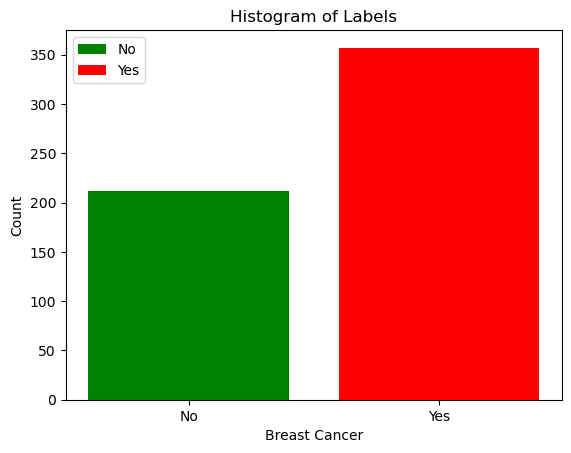

In [7]:
# Plot value counts
plt.hist(data[data['target'] == 0]['target'], bins=[-0.5, 0.5, 1.5], color='green', rwidth=0.8, label='No')
plt.hist(data[data['target'] == 1]['target'], bins=[-0.5, 0.5, 1.5], color='red', rwidth=0.8, label='Yes')
plt.xlabel('Breast Cancer')
plt.ylabel('Count')
plt.title('Histogram of Labels')
plt.xticks([0, 1], ['No', 'Yes'])
plt.legend()
plt.show()


In [8]:
def generate_feat(feat, num_samples=200):
    X = np.zeros((num_samples, feat.shape[1]), dtype='float64')
    for j in tqdm(range(feat.shape[1]), desc="data gen. for each feat..."):
        dfit = distfit(distr='popular', n_boots=100, verbose=0)
        dfit.fit_transform(feat[:,j])
        X[:,j] = dfit.generate(num_samples)
    return X
    

In [9]:
# group data based on labels separately to generate synthetic data for each group
num_samples_per_class = 200
num_samples = num_samples_per_class * len(labels)
X_synt = np.zeros((num_samples, X_train_sel.shape[1]), dtype='float64')
y_synt = np.zeros((num_samples,), dtype='int64')
start = 0
for label in tqdm(labels, desc="overall process..."):
    print("label", label)
    X = X_train_sel[y_train == label]
    X_synt[start:start + num_samples_per_class, :] = generate_feat(X, num_samples_per_class)
    y_synt[start:start + num_samples_per_class] = label
    start += num_samples_per_class
    

overall process...:   0%|          | 0/2 [00:00<?, ?it/s]

label 0



overall process...:  50%|█████     | 1/2 [03:18<03:18, 198.23s/it]

label 1



overall process...: 100%|██████████| 2/2 [07:30<00:00, 225.33s/it]


In [10]:
# classifing using XGBoost on real data with default hyperparameters
model = XGBClassifier(random_state=42)
model.fit(X_train_sel, y_train)
y_pred = model.predict(X_test_sel)
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"F1 (macro): {f1_macro:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9649
F1 (macro): 0.9623
Confusion Matrix:
[[40  2]
 [ 2 70]]


In [11]:
# let's use our synthetic data
X_synt, y_synt = shuffle(X_synt, y_synt, random_state=42)
model = XGBClassifier(random_state=42)
model.fit(X_synt, y_synt)
y_pred = model.predict(X_test_sel)
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"F1 (macro): {f1_macro:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9035
F1 (macro): 0.8994
Confusion Matrix:
[[40  2]
 [ 9 63]]
